# Quantization Framework for Neural Networks
<b> >>This flow accepts the Pruned Model and Quantizes its Weights to the nearest power of 2<br>
<b> >>The Quantized model is saved into a file and performance of the Quantized model is evaluated

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# For Generating MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from keras.constraints import Constraint
import keras.backend as K
import math
import scipy.io

<b>2. Prepare MNIST Dataset

In [2]:
# Dataset Preparation
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

<b>3. Train MLP on MNIST</b><br>

In [3]:
from tensorflow.keras.constraints import max_norm
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),   
  keras.layers.Flatten(),                    
  keras.layers.Dense(32, activation=tf.nn.relu),
  keras.layers.Dense(16, activation=tf.nn.relu),
  keras.layers.Dense(10, activation=tf.nn.softmax)
])
# Train the digit classification model
model.compile(optimizer=keras.optimizers.RMSprop(),
loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.1,
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 49us/sample - loss: 0.3961 - acc: 0.8859 - val_loss: 0.1868 - val_acc: 0.9467
Epoch 2/10
54000/54000 [==============================] - 2s 45us/sample - loss: 0.1956 - acc: 0.9425 - val_loss: 0.1450 - val_acc: 0.9592
Epoch 3/10
54000/54000 [==============================] - 2s 41us/sample - loss: 0.1574 - acc: 0.9541 - val_loss: 0.1257 - val_acc: 0.9632
Epoch 4/10
54000/54000 [==============================] - 2s 42us/sample - loss: 0.1371 - acc: 0.9604 - val_loss: 0.1247 - val_acc: 0.9645
Epoch 5/10
54000/54000 [==============================] - 2s 42us/sample - loss: 0.1240 - acc: 0.9648 - val_loss: 0.1227 - val_acc: 0.9638
Epoch 6/10
54000/54000 [==============================] - 2s 41us/sample - loss: 0.1132 - acc: 0.9671 - val_loss: 0.1228 - val_acc: 0.9677
Epoch 7/10
54000/54000 [=====================

<b>4. Obtain Model Parameter Statistics</b><br>

Functions to do the following tasks:
1. <b>evaluate(x_inp)</b> :->returns the layer-wise output values of all layers <br>
2. <b>relu(w)  </b>       :->ReLu<br>
3. <b>quantize_power2(w1)</b> :-> Quantize to nearest power of 2 (Only for Histogram plotting)<br>
4. <b>plot_hist(w_mat,name)</b>:-> Histogram Plotter
5. <b>quantToNearestPowerOf2(w1)</b>:-> Actual Quantization hppens here (based on Histogram Outputs)
6. <b>forward(x_inp,w1,b1,w2,b2,w3,b3)</b>:-> Forward Path calculation Range: To obtain Performance of the Quantized Network

In [22]:
# Evaluate without RELU TO be get max range
def evaluate(x_inp):
    '''This function returns the layer-wise output values of all layers'''
    w1 = model.layers[1].get_weights()
    w2 = model.layers[2].get_weights()
    w3 = model.layers[3].get_weights()
    acc1 = np.squeeze(np.matmul(w1[0].T,x_inp))+w1[1]

    #print(np.matmul(w1[0].T,x_inp))
    layer1_op = relu(acc1)
    acc2 = np.squeeze(np.matmul(w2[0].T,layer1_op))+w2[1]
    layer2_op = relu(acc2)
    layer3_op = np.squeeze(np.matmul(w3[0].T,layer2_op))+w3[1]
    predict = np.argmax(layer3_op)
    return acc1,acc2,layer1_op, layer2_op, layer3_op,predict
# RELU Function
def relu(w):
    op =[x if x > 0 else 0 for x in w]
    return op 

# Quantize weights for nearest power of 2
# Only for histogram plotting
def quantize_power2(w1):
    
    if len(w1.shape) ==2 :  # for 2d arrays
        powers = range(-8,9)
        q_lookup = [2**x for x in powers]
        for row in range(w1.shape[0]):
            for col in range(w1.shape[1]):
                abs_ele = abs(w1[row][col])
                ele_sel = q_lookup[0]
                for i in q_lookup:
                    if abs_ele > i:
                        ele_sel = i
                w1[row][col] = math.log(ele_sel,2)
    elif len(w1.shape) ==2 :  # for 1d arrays
        powers = range(-8,9)
        q_lookup = [2**x for x in powers]
        for row in range(w1.shape):
            abs_ele = abs(w1[row])
            for i in q_lookup:
                if abs_ele > i:
                    ele_sel = i
            w1[row] = math.log(ele_sel,2)
    return w1
#---------------------------------------------------------------------
def plot_hist(w_mat,name):
    weights= np.array(w_mat)
    weights =weights.reshape(-1,1)
    plt.style.use('dark_background')
    #hist,bins=np.histogram(weights,bins=[-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
    plt.figure()
    plt.title("histogram of "+name) 
    plt.hist(weights,bins=[-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9],color = "green")
    print("plotting Histogram of datapoints of size",format(weights.shape))
    plt.show()

def quantToNearestPowerOf2(w1):
    '''
    From weights in Histogram , we see that all weights are within [-2,2]
    Thus, to quantize them to powers to 2, each weight shall be mapped to one of  
    [-2,-1,-0.5 -0.25 -0.125 0 +0.125 +0.25 +0.5 +1 +2]
    
    '''
    if len(w1.shape) ==2 :  # for 2d arrays
        q_lookup = [-2,-1,-0.5, -0.25, -0.125, 0, +0.125, +0.25, +0.5, +1, +2]
        for row in range(w1.shape[0]):
            for col in range(w1.shape[1]):
                element = w1[row][col]
                diff = np.array([abs(i - element) for i in q_lookup])
                min_diff_index = np.argmin(diff)
                w1[row][col] = q_lookup[min_diff_index]
    else :  # for 1d arrays
        q_lookup = [-2,-1,-0.5, -0.25, -0.125, 0, +0.125, +0.25, +0.5, +1, +2]
        for row in range(w1.shape[0]):
            element = w1[row]
            diff = np.array([abs(i - element) for i in q_lookup])
            min_diff_index = np.argmin(diff)
            w1[row] = q_lookup[min_diff_index]
    return w1

def forward(x_inp,w1,b1,w2,b2,w3,b3):
    acc1 = np.squeeze(np.matmul(w1.T,x_inp))+b1
    layer1_op = relu(acc1)
    acc2 = np.squeeze(np.matmul(w2.T,layer1_op))+b2
    layer2_op = relu(acc2)
    layer3_op = np.squeeze(np.matmul(w3.T,layer2_op))+b3
    predict = np.argmax(layer3_op)
    return acc1,acc2,layer1_op, layer2_op, layer3_op,predict

<b>4.a Obtain Intermediate layer Outputs for all inputs in Training Dataset</b><br>

In [7]:
# Obtain Histogram of all Weights and Layer Outputs
layer1_ops = []
layer2_ops = []
layer3_ops = []
acc1s = []
acc2s =[]
predictions=[]
for img in test_images:
    x_inp = img.reshape(784,1)
    acc1, acc2, layer1_op, layer2_op, layer3_op, predict = evaluate(x_inp)
    layer1_ops.append(layer1_op)
    layer2_ops.append(layer2_op)
    layer3_ops.append(layer3_op)
    acc1s.append(acc1)
    acc2s.append(acc2)
    predictions.append(predict)

<b>4b. Obtain Histograms of all weights, biases and intermediate layer outputs

plotting Histogram of datapoints of size (320000, 1)


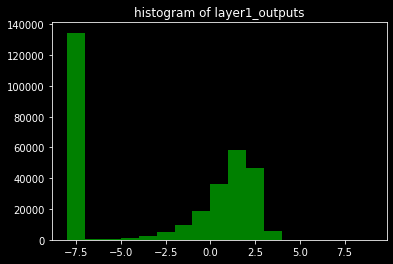

plotting Histogram of datapoints of size (160000, 1)


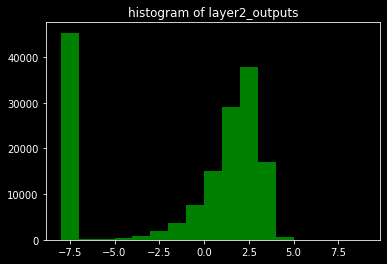

plotting Histogram of datapoints of size (100000, 1)


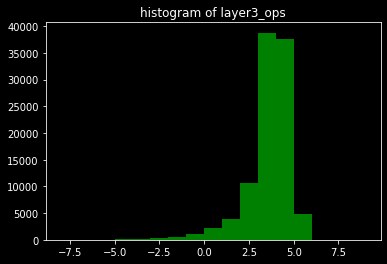

plotting Histogram of datapoints of size (25088, 1)


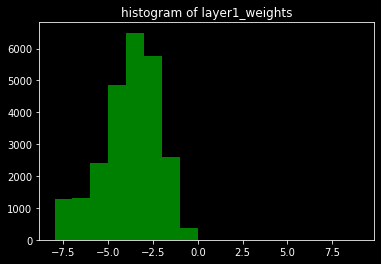

plotting Histogram of datapoints of size (512, 1)


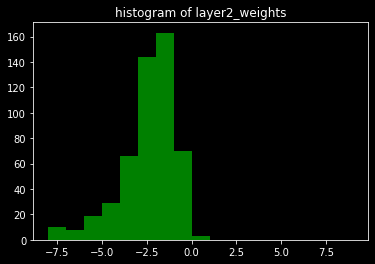

plotting Histogram of datapoints of size (160, 1)


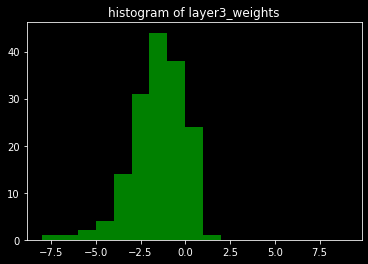

plotting Histogram of datapoints of size (32, 1)


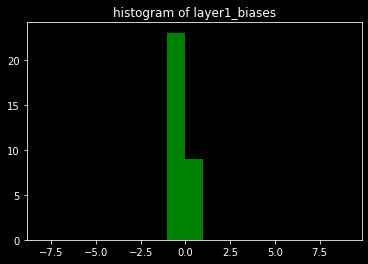

plotting Histogram of datapoints of size (16, 1)


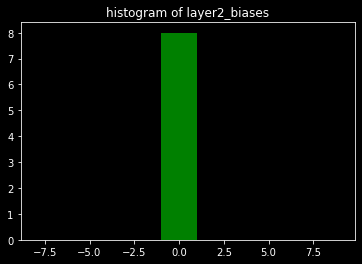

plotting Histogram of datapoints of size (10, 1)


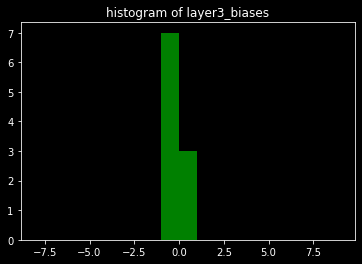

In [15]:
# Get Histogram of Weights
w1 = model.layers[1].get_weights()[0]
w2 = model.layers[2].get_weights()[0]
w3 = model.layers[3].get_weights()[0]
b1 = model.layers[1].get_weights()[1]
b2 = model.layers[2].get_weights()[1]
b3 = model.layers[3].get_weights()[1]

w1_q = quantize_power2(w1)
w2_q = quantize_power2(w2)
w3_q = quantize_power2(w3)
b1_q = quantize_power2(b1)
b2_q = quantize_power2(b2)
b3_q = quantize_power2(b3)

layer1_ops_q = quantize_power2(np.array(layer1_ops))
layer2_ops_q = quantize_power2(np.array(layer2_ops))
layer3_ops_q = quantize_power2(np.array(layer3_ops))

plot_hist(layer1_ops_q,'layer1_outputs')
plot_hist(layer2_ops_q,'layer2_outputs')
plot_hist(layer3_ops_q,'layer3_ops')
plot_hist(w1_q,'layer1_weights')
plot_hist(w2_q,'layer2_weights')
plot_hist(w3_q,'layer3_weights')
plot_hist(b1_q,'layer1_biases')
plot_hist(b2_q,'layer2_biases')
plot_hist(b3_q,'layer3_biases')


<b>4c. Save Quantized Model in a file

In [19]:
import scipy.io
w1 = model.layers[1].get_weights()[0]
w2 = model.layers[2].get_weights()[0]
w3 = model.layers[3].get_weights()[0]
b1 = model.layers[1].get_weights()[1]
b2 = model.layers[2].get_weights()[1]
b3 = model.layers[3].get_weights()[1]

layer1_ops = []
layer2_ops = []
layer3_ops = []
acc1s = []
acc2s =[]
predictions=[]
# Define new weights as quantized to power to 2 weights
w1_q2 = quantToNearestPowerOf2(w1)
w2_q2 = quantToNearestPowerOf2(w2)
w3_q2 = quantToNearestPowerOf2(w3)

b1_q2 = quantToNearestPowerOf2(b1)
b2_q2 = quantToNearestPowerOf2(b2)
b3_q2 = quantToNearestPowerOf2(b3)

export 2-power quantized weights to matlab
import scipy.io
scipy.io.savemat('power2_q.mat', \
                 dict(labels=test_labels,\
                      w1=w1_q2,b1=b1_q2,\
                      w2=w2_q2,b2=b2_q2,\
                      w3=w3_q2,b3=b3_q2))

# Evaluate Accuracy
for img in test_images:
    x_inp = img.reshape(784,1)
    x_inp_q = quantToNearestPowerOf2(x_inp)
    acc1, acc2, layer1_op, layer2_op, layer3_op, predict \
            = forward(x_inp,w1_q2,b1_q2,w2_q2,b2_q2,w3_q2,b3_q2)
    layer1_ops.append(layer1_op)
    layer2_ops.append(layer2_op)
    layer3_ops.append(layer3_op)
    acc1s.append(acc1)
    acc2s.append(acc2)
    predictions.append(predict)

<b> 5. Evaluate Performance of the Quantized Model

In [25]:
import scipy.io
w1 = model.layers[1].get_weights()[0]
w2 = model.layers[2].get_weights()[0]
w3 = model.layers[3].get_weights()[0]
b1 = model.layers[1].get_weights()[1]
b2 = model.layers[2].get_weights()[1]
b3 = model.layers[3].get_weights()[1]

layer1_ops = []
layer2_ops = []
layer3_ops = []
acc1s = []
acc2s =[]
predictions=[]
# Define new weights as quantized to power to 2 weights
w1_q2 = quantToNearestPowerOf2(w1)
w2_q2 = quantToNearestPowerOf2(w2)
w3_q2 = quantToNearestPowerOf2(w3)

b1_q2 = quantToNearestPowerOf2(b1)
b2_q2 = quantToNearestPowerOf2(b2)
b3_q2 = quantToNearestPowerOf2(b3)


# Evaluate Accuracy
for img in test_images:
    x_inp = img.reshape(784,1)
    x_inp_q = quantToNearestPowerOf2(x_inp)
    acc1, acc2, layer1_op, layer2_op, layer3_op, predict \
            = forward(x_inp,w1_q2,b1_q2,w2_q2,b2_q2,w3_q2,b3_q2)
    layer1_ops.append(layer1_op)
    layer2_ops.append(layer2_op)
    layer3_ops.append(layer3_op)
    acc1s.append(acc1)
    acc2s.append(acc2)
    predictions.append(predict)
accuracy= 1-np.count_nonzero(predictions-test_labels)/10000
print("Accuracy of the Quantized Model after evaluating on MNIST Test Dataset is :{:.3}".format(100*accuracy)) 

Accuracy of the Quantized Model after evaluating on MNIST Test Dataset is :94.2
